In [1]:
! pip install -U -q jax-cfd[complete]==0.1.0

     |████████████████████████████████| 134 kB 4.7 MB/s 
     |████████████████████████████████| 41 kB 258 kB/s 
     |████████████████████████████████| 287 kB 7.9 MB/s 
     |████████████████████████████████| 280 kB 10.1 MB/s 
     |████████████████████████████████| 280 kB 8.0 MB/s 
     |████████████████████████████████| 280 kB 36.3 MB/s 
     |████████████████████████████████| 280 kB 10.7 MB/s 
     |████████████████████████████████| 279 kB 11.7 MB/s 
     |████████████████████████████████| 279 kB 23.2 MB/s 
     |████████████████████████████████| 40 kB 3.3 MB/s 
     |████████████████████████████████| 40 kB 2.1 MB/s 
     |████████████████████████████████| 163 kB 32.2 MB/s 
     |████████████████████████████████| 324 kB 38.5 MB/s 
     |████████████████████████████████| 272 kB 37.4 MB/s 
     |████████████████████████████████| 272 kB 43.3 MB/s 
     |████████████████████████████████| 272 kB 40.3 MB/s 
     |████████████████████████████████| 270 kB 48.2 MB/s 
     |█████████████████

In [2]:
dataset_name = 'kolmogorov_re_1000'  #@param ['kolmogorov_re_1000', 'decaying', 'kolmogorov_re_4000'] {type: "string"}

In [3]:
%time ! gsutil -m cp gs://gresearch/jax-cfd/public_eval_datasets/{dataset_name}/eval_*.nc /content

Copying gs://gresearch/jax-cfd/public_eval_datasets/kolmogorov_re_1000/eval_128x128_64x64.nc...
Copying gs://gresearch/jax-cfd/public_eval_datasets/kolmogorov_re_1000/eval_1024x1024_64x64.nc...
Copying gs://gresearch/jax-cfd/public_eval_datasets/kolmogorov_re_1000/eval_2048x2048_64x64.nc...
Copying gs://gresearch/jax-cfd/public_eval_datasets/kolmogorov_re_1000/eval_64x64_64x64.nc...
Copying gs://gresearch/jax-cfd/public_eval_datasets/kolmogorov_re_1000/eval_256x256_64x64.nc...
Copying gs://gresearch/jax-cfd/public_eval_datasets/kolmogorov_re_1000/eval_512x512_64x64.nc...
- [6/6 files][  2.9 GiB/  2.9 GiB] 100% Done  41.7 MiB/s ETA 00:00:00           
Operation completed over 6 objects/2.9 GiB.                                      
CPU times: user 692 ms, sys: 112 ms, total: 804 ms
Wall time: 52.2 s


In [4]:
%time ! gsutil -m cp gs://gresearch/jax-cfd/public_models/*.pkl /content

Copying gs://gresearch/jax-cfd/public_models/EPD_ckpt.pkl...
Copying gs://gresearch/jax-cfd/public_models/LC_ckpt.pkl...
Copying gs://gresearch/jax-cfd/public_models/LI_ckpt.pkl...
/ [3/3 files][  3.8 MiB/  3.8 MiB] 100% Done                                    
Operation completed over 3 objects/3.8 MiB.                                      
CPU times: user 62.3 ms, sys: 8.41 ms, total: 70.7 ms
Wall time: 4.38 s


In [5]:
! ls /content

EPD_ckpt.pkl		 eval_256x256_64x64.nc	LI_ckpt.pkl
eval_1024x1024_64x64.nc  eval_512x512_64x64.nc	sample_data
eval_128x128_64x64.nc	 eval_64x64_64x64.nc
eval_2048x2048_64x64.nc  LC_ckpt.pkl


In [6]:
#@title Imports { form-width: "30%" }

import warnings
warnings.simplefilter('ignore')

import os
import functools
import pickle

import gin
import jax
import jax.numpy as jnp
import numpy as np
import haiku as hk

import xarray
import seaborn
import matplotlib.pyplot as plt

import jax_cfd.base as cfd
import jax_cfd.data as cfd_data
import jax_cfd.ml as ml

model_builder = ml.model_builder
model_utils = ml.model_utils
optimizer_modules = ml.optimizer_modules
physics_specifications = ml.physics_specifications

In [7]:
#@title Helper functions

shape_structure = lambda tree: jax.tree_map(lambda x: x.shape, tree)


def xarray_open(path):
  return xarray.open_dataset(path, chunks={'time': '100MB'})


def strip_imports(s):
  out_lines = []
  for line in s.splitlines():
    if not line.startswith('import'):
      out_lines.append(line)
  return '\n'.join(out_lines)

# Selecting evaluation dataset

In [8]:
#@title Paths to evaluation datasets

base_path = '/content/'

kolmogorov_re_1000 = {
    f'baseline_{i}x{i}': os.path.join(base_path, f'eval_{i}x{i}_64x64.nc')
    for i in [64, 128, 256, 512, 1024, 2048]
}
decaying = {
    f'baseline_{i}x{i}': os.path.join(base_path, f'eval_{i}x{i}_64x64.nc')
    for i in [64, 128, 256, 512, 1024, 2048]
}
kolmogorov_re_4000 = {
    f'baseline_{i}x{i}': os.path.join(base_path, f'eval_{i}x{i}_128x128.nc')
    for i in [128, 256, 512, 1024, 2048, 4096]
}

all_datasets = {
    'kolmogorov_re_1000': kolmogorov_re_1000,
    'decaying': decaying,
    'kolmogorov_re_4000': kolmogorov_re_4000,
}

reference_names = {
    'kolmogorov_re_1000': 'baseline_2048x2048',
    'decaying': 'baseline_2048x2048',
    'kolmogorov_re_4000': 'baseline_4096x4096',
}

In [9]:
! ls /content/

EPD_ckpt.pkl		 eval_256x256_64x64.nc	LI_ckpt.pkl
eval_1024x1024_64x64.nc  eval_512x512_64x64.nc	sample_data
eval_128x128_64x64.nc	 eval_64x64_64x64.nc
eval_2048x2048_64x64.nc  LC_ckpt.pkl


In [10]:
#@title Loading evaluation dataset {run: "auto"}

dataset_paths = all_datasets[dataset_name]
datasets = {k: xarray_open(v) for k, v in dataset_paths.items()}
reference_ds = datasets[reference_names[dataset_name]]

grid = cfd_data.xarray_utils.grid_from_attrs(reference_ds.attrs)

In [11]:
#@title Selecting initial conditions and baseline trajectories.

sample_id = 0
time_id = 0
length = 200  # length of the trajectory.
inner_steps = 10  # since we deal with subsampled datasets

initial_conditions = tuple(
    reference_ds[velocity_name].isel(
        sample=slice(sample_id, sample_id + 1),
        time=slice(time_id, time_id + 1)
    ).values
    for velocity_name in cfd_data.xarray_utils.XR_VELOCITY_NAMES[:grid.ndim]
)

target_ds = reference_ds.isel(
    sample=slice(sample_id, sample_id + 1),
    time=slice(time_id, time_id + length))


datasets = {
    k: v.isel(sample=slice(sample_id, sample_id + 1),
              time=slice(time_id, time_id + length))
    for k, v in datasets.items()
}

# Selecting model checkpoint to load

In [12]:
class CheckpointState:
  """Object to package up the state we load and restore."""

  def __init__(self, **kwargs):
    for name, value in kwargs.items():
      setattr(self, name, value)

In [13]:
checkpoint_paths = {
    'LI': "/content/LI_ckpt.pkl",
    'LC': "/content/LC_ckpt.pkl",
    'EPD': "/content/EPD_ckpt.pkl",
}

In [14]:
#@title selecting model to evaluate {run: "auto"}

model_name = "LI" #@param ['LI', 'LC', 'EPD',] {type: "string"}

In [15]:
#@title Loading the checkpoint

ckpt_path = checkpoint_paths[model_name]
with open(ckpt_path, 'rb') as f:
  ckpt = pickle.load(f)
params = ckpt.eval_params

In [16]:
shape_structure(params)

FlatMap({
  'modular_step_model/~/navier_stokes_step_fn/fused_learned_interpolation/periodic_conv_2d/~/conv2_d': FlatMap({'b': (64,), 'w': (3, 3, 2, 64)}),
  'modular_step_model/~/navier_stokes_step_fn/fused_learned_interpolation/periodic_conv_2d_1/~/conv2_d': FlatMap({'b': (64,), 'w': (3, 3, 64, 64)}),
  'modular_step_model/~/navier_stokes_step_fn/fused_learned_interpolation/periodic_conv_2d_2/~/conv2_d': FlatMap({'b': (64,), 'w': (3, 3, 64, 64)}),
  'modular_step_model/~/navier_stokes_step_fn/fused_learned_interpolation/periodic_conv_2d_3/~/conv2_d': FlatMap({'b': (64,), 'w': (3, 3, 64, 64)}),
  'modular_step_model/~/navier_stokes_step_fn/fused_learned_interpolation/periodic_conv_2d_4/~/conv2_d': FlatMap({'b': (64,), 'w': (3, 3, 64, 64)}),
  'modular_step_model/~/navier_stokes_step_fn/fused_learned_interpolation/periodic_conv_2d_5/~/conv2_d': FlatMap({'b': (64,), 'w': (3, 3, 64, 64)}),
  'modular_step_model/~/navier_stokes_step_fn/fused_learned_interpolation/periodic_conv_2d_6/~/conv

# Model inference

In [17]:
#@title Setting up model configuration from the checkpoint;

gin.clear_config()
gin.parse_config(ckpt.model_config_str)
gin.parse_config(strip_imports(reference_ds.attrs['physics_config_str']))
dt = ckpt.model_time_step
physics_specs = physics_specifications.get_physics_specs()
model_cls = model_builder.get_model_cls(grid, dt, physics_specs)


def compute_trajectory_fwd(x):
  solver = model_cls()
  x = solver.encode(x)
  final, trajectory = solver.trajectory(
      x, length, inner_steps, start_with_input=True, post_process_fn=solver.decode)
  return trajectory


model = hk.without_apply_rng(hk.transform(compute_trajectory_fwd))
trajectory_fn = functools.partial(model.apply, params)
trajectory_fn = jax.vmap(trajectory_fn)  # predict a batch of trajectories;

In [18]:
#@title Running inference;

prediction = trajectory_fn(initial_conditions)
prediction_ds = cfd_data.xarray_utils.velocity_trajectory_to_xarray(
    prediction, grid, samples=True)

# roundoff error in coordinates sometimes leads to wrong alignment results;
prediction_ds.coords['x'] = target_ds.coords['x']
prediction_ds.coords['y'] = target_ds.coords['y']
prediction_ds.coords['time'] = target_ds.coords['time']

datasets[model_name] = prediction_ds

# Computing summaries

**Note:** Evaluations in this notebook are demonstrative and performed over a single sample and shorter times than those used in the paper;

In [19]:
summary = xarray.concat([
    cfd_data.evaluation.compute_summary_dataset(ds, target_ds)
    for ds in datasets.values()
], dim='model')
summary.coords['model'] = list(datasets.keys())

correlation = summary.vorticity_correlation.compute()
spectrum = summary.energy_spectrum_mean.mean('time').compute()

In [20]:
baseline_palette = seaborn.color_palette('YlGnBu', n_colors=7)[1:]
models_color = seaborn.xkcd_palette(['burnt orange', 'taupe', 'greenish blue'])
palette = baseline_palette + models_color[:(len(datasets.keys()) - 6)]

(0.0, 15.0)

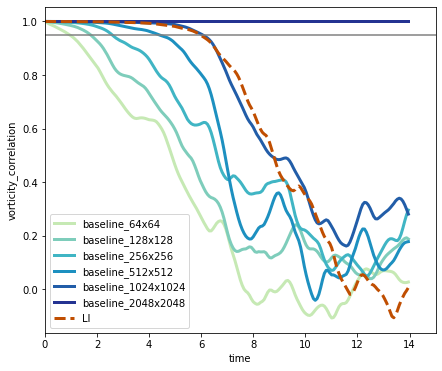

In [21]:
#@title Vorticity correlation as a function of time

plt.figure(figsize=(7, 6))
for color, model in zip(palette, summary['model'].data):
  style = '-' if 'baseline' in model else '--'
  correlation.sel(model=model).plot.line(
      color=color, linestyle=style, label=model, linewidth=3);
plt.axhline(y=0.95, xmin=0, xmax=20, color='gray')
plt.legend();
plt.title('')
plt.xlim(0, 15)

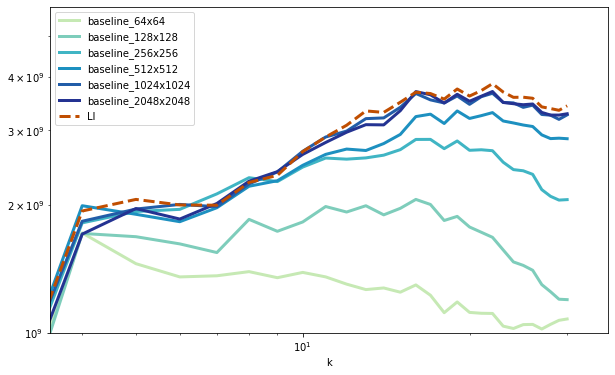

In [22]:
#@title Energy spectrum

plt.figure(figsize=(10, 6))
for color, model in zip(palette, summary['model'].data):
  style = '-' if 'baseline' in model else '--'
  (spectrum.k ** 5 * spectrum).sel(model=model).plot.line(
      color=color, linestyle=style, label=model, linewidth=3);
plt.legend();
plt.yscale('log')
plt.xscale('log')
plt.title('')
plt.xlim(3.5, None)
if dataset_name == 'kolmogorov_re_4000':
  plt.ylim(5e8, None)
elif dataset_name == 'kolmogorov_re_1000':
  plt.ylim(1e9, None)
elif dataset_name == 'decaying':
  plt.ylim(2e8, None)
else:
  raise ValueError('Unrecognized dataset')

In [23]:
vorticities = xarray.concat(
    [cfd_data.xarray_utils.vorticity_2d(ds) for ds in datasets.values()],
    dim='model'
).to_dataset()
vorticities.coords['model'] = list(datasets.keys())

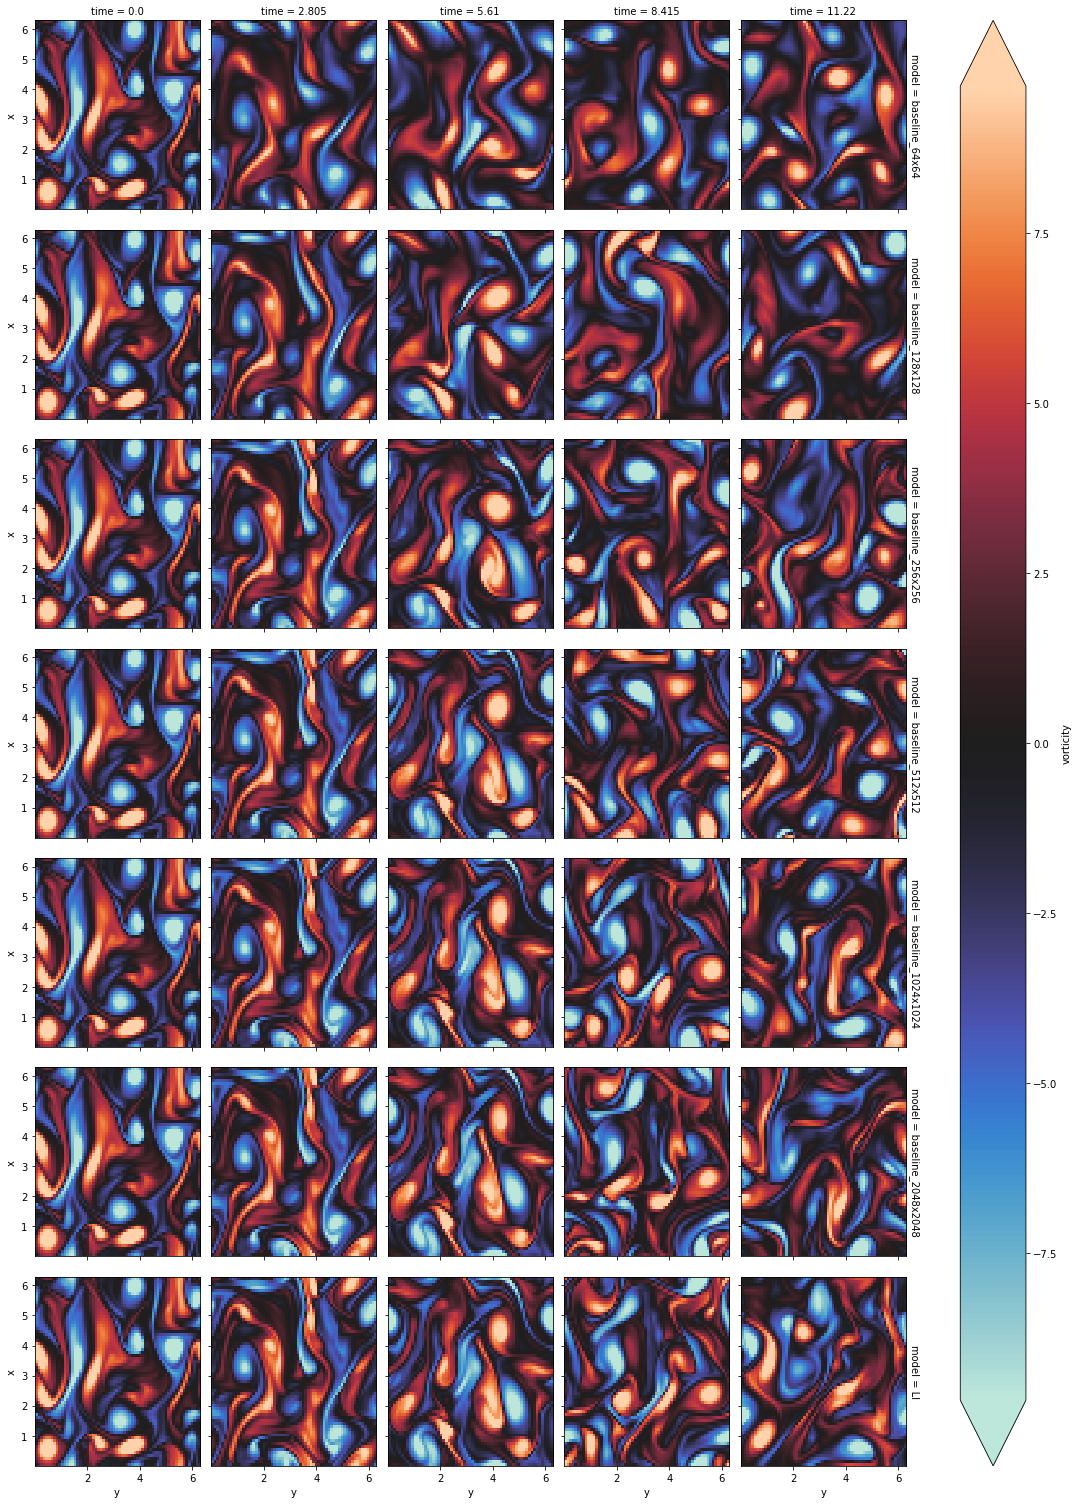

In [24]:
#@title Visualizing model unrolls { form-width: "30%", run: "auto"}
time_range = {'min': 0, 'max': vorticities.sizes['time'], 'step': 1}

last_step_to_plot = 200 #@param {type: "slider", min: 1, max: 200 , step: 5}
num_to_show = 5 #@param {type: "slider", min: 1, max: 10, step: 1}
time_slice = slice(None, last_step_to_plot, last_step_to_plot // num_to_show)

(vorticities.isel({'time': time_slice, 'sample': 0})['vorticity']
 .plot.imshow(row='model', col='time', cmap=seaborn.cm.icefire, robust=True))